### TD-DFT Example Notebook

This notebook demonstrates how to use the TD-DFT module in QuantumMASALA to calculate the absorption spectrum of Methane (Ch4) molecule.

The notebook is divided into the following sections:
1. Obtaining the ground state wavefunctions using scf module
2. Time propagation of the wavefunctions using tddft module
3. Visualization of the absorption spectrum

In [20]:
import numpy as np
import os
from qtm.config import qtmconfig
from qtm.constants import RYDBERG, ELECTRONVOLT
from qtm.containers.wavefun import get_WavefunG
from qtm.lattice import RealLattice
from qtm.crystal import BasisAtoms, Crystal
from qtm.pseudo import UPFv2Data
from qtm.kpts import gen_monkhorst_pack_grid, KList
from qtm.gspace import GSpace
from qtm.mpi import QTMComm
from qtm.dft import DFTCommMod, scf

from qtm.io_utils.dft_printers import print_scf_status

from qtm.logger import qtmlogger
from qtm.tddft_gamma.optical import dipole_response
# qtmconfig.fft_backend = 'mkl_fft'

DEBUGGING = True


from mpi4py.MPI import COMM_WORLD
comm_world = QTMComm(COMM_WORLD)
dftcomm = DFTCommMod(comm_world, comm_world.size, 1)

# Lattice
reallat = RealLattice.from_alat(alat=30.0, # Bohr
                                a1=[1., 0., 0.],
                                a2=[0., 1., 0.],
                                a3=[0., 0., 1.])


# Atom Basis
c_oncv = UPFv2Data.from_file('C_ONCV_PBE-1.2.upf')
h_oncv = UPFv2Data.from_file('H_ONCV_PBE-1.2.upf')

# C atom at the center of the cell
c_atoms = BasisAtoms.from_angstrom('C', c_oncv, 12.011, reallat,
                                  0.529177*np.array([15., 15., 15.]))
coords_ang = 0.642814093
h_atoms = coords_ang * np.array(
    [[ 1,  1,  1],
     [-1, -1,  1],
     [ 1, -1, -1],
     [-1,  1, -1]])
# Shift the H atoms to the center of the cell
h_atoms += 0.529177 * 15.0 * np.ones_like(h_atoms)
h_atoms = BasisAtoms.from_angstrom('H', h_oncv, 1.000, reallat,
                                  *h_atoms)



crystal = Crystal(reallat, [c_atoms, h_atoms])
kpts = KList.gamma(crystal.recilat)
print(kpts.numkpts)


# -----Setting up G-Space of calculation-----
ecut_wfn = 25 * RYDBERG
# NOTE: In future version, hard grid (charge/pot) and smooth-grid (wavefun)
# can be set independently
ecut_rho = 4 * ecut_wfn
gspc_rho = GSpace(crystal.recilat, ecut_rho)
gspc_wfn = gspc_rho

print("gspc_rho.reallat_dv", gspc_rho.reallat_dv)



is_spin, is_noncolin = False, False
numbnd = crystal.numel // 2
occ = 'fixed'
conv_thr = 1E-10 * RYDBERG
diago_thr_init = 1E-5 * RYDBERG

out = scf(dftcomm, crystal, kpts, gspc_rho, gspc_wfn,
        numbnd, is_spin, is_noncolin,
        occ_typ=occ,
        conv_thr=conv_thr, diago_thr_init=diago_thr_init,
        iter_printer=print_scf_status)

scf_converged, rho, l_wfn_kgrp, en = out

WavefunG = get_WavefunG(l_wfn_kgrp[0][0].gkspc, 1)


print("SCF Routine has exited")
print(qtmlogger)


1
gspc_rho.reallat_dv 0.030517578125000003
Quantum MASALA
 - Project Git Info:
    - Commit hash:          fc64aef1726fd1dc016fc2feff3954d7e707fba7
    - Commit date and time: Wednesday, 11 September, 2024 11:04:51
SCF Parameters:

- dftcomm:           DFTCommMod(image_comm=<qtm.mpi.comm.QTMComm object at 0x7a4307f81350>, image_comm.size=1, n_kgrp=1, n_bgrp=1, pwgrp_size=None, 
- crystal:           Crystal(
    reallat=RealLattice(
          alat=30.0, 
          latvec=
            [[30.  0.  0.]
             [ 0. 30.  0.]
             [ 0.  0. 30.]],
        ), 
    l_atoms=[
    	BasisAtoms(
    	  label='C', 
    	  ppdata.md5_checksum=1a5f83a7b1f58d24996abe00ed223ac6, 
    	  mass=12.011, 
    	  r_cryst=
    	    [0.4999998, 0.4999998, 0.4999998],
    	  )
    	BasisAtoms(
    	  label='H', 
    	  ppdata.md5_checksum=bf21e08b90ac4ce7d0149ac4e8138190, 
    	  mass=1.0, 
    	  r_cryst=
    	    [0.54049122, 0.54049122, 0.54049122],
    	    [0.45950838, 0.45950838, 0.54049122],
 

In [21]:
from qtm.config import qtmconfig
# -----------------------
# BEGIN TDDFT CALCULATION
# -----------------------
gamma_efield_kick = 1e-4 # Electric field kick (in z-direction) in Hartree atomic units, 0.0018709241 Ry/e_Ry/Bohr = 0.01 Ha/e_Ha/Angstrom
time_step = 0.1    # Time in Hartree atomic units 1 Hartree a.u. = 2.4188843265864(26)×10−17 s ~ 24.1888 attoseconds 
                    # Reference calculation (ce-tddft) had 2.4 attosecond time step.
numsteps = 1000

qtmconfig.tddft_prop_method = 'etrs'
qtmconfig.tddft_exp_method = 'taylor'


# Pretty-print the input parameters for tddft
print("TDDFT Parameters:")
print("Electric field kick:", gamma_efield_kick)
print("Time step:", time_step)
print("Number of steps:", numsteps)
print("Propagation method:", qtmconfig.tddft_prop_method)
print("Exponential evaluation method:", qtmconfig.tddft_exp_method)
print(kpts.k_weights)

dip_z = dipole_response(comm_world, crystal, l_wfn_kgrp,
                        time_step, numsteps, gamma_efield_kick, 'z')


# TODO: Save the dipole response to a HDF5 file, with all the necessary metadata.
fname = 'dipz.npy'
if os.path.exists(fname) and os.path.isfile(fname):
    os.remove(fname)
np.save(fname, dip_z)



TDDFT Parameters:
Electric field kick: 0.0001
Time step: 0.1
Number of steps: 1000
Propagation method: etrs
Exponential evaluation method: taylor
[1.]
config.tddft_exp_method: taylor


100%|██████████| 1000/1000 [32:52<00:00,  1.97s/it]


Shape of dipole moment array: (1001, 3)


Text(0.5, 1.0, 'Dipole Response vs Time')

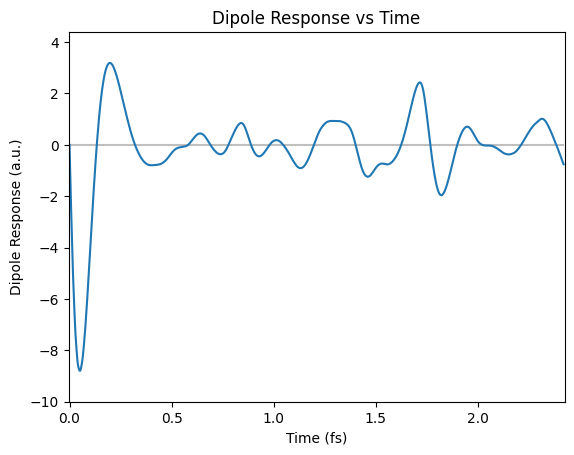

In [53]:
# --------------------------------
# Plotting the Absorption Spectrum
# --------------------------------

import matplotlib.pyplot as plt
from scipy.constants import eV, c

dip_z = np.load('dipz.npy')
dip_z = dip_z[:] - dip_z[0]    # Subtract the initial dipole moment
print("Shape of dipole moment array:", dip_z.shape)


# Plot in time domain

au_to_fs = 2.418884326505e-2
time = np.arange(0, (numsteps+1)*time_step, time_step) * au_to_fs  # Convert to femtoseconds
plt.hlines(0, 0, numsteps*time_step*au_to_fs, colors='grey', alpha=0.5)
plt.margins(0.002, 0.1)
plt.plot(time, dip_z[:,2])
plt.xlabel("Time (fs)")
plt.ylabel("Dipole Response (a.u.)")
plt.title("Dipole Response vs Time")
# plt.grid()

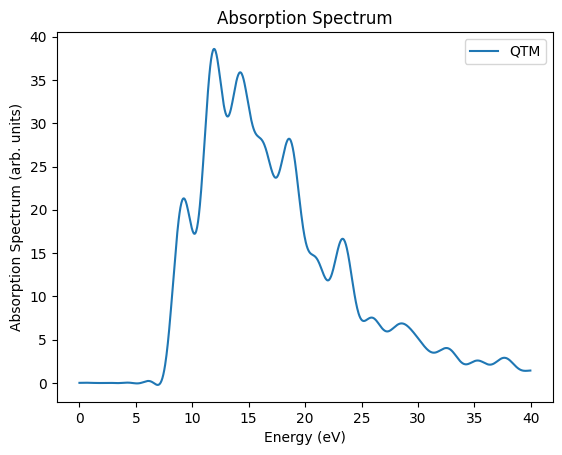

In [49]:
# Plot in frequency domain

from qtm.tddft_gamma.optical import dipole_spectrum

dim = 2   # z-component of the dipole moment
en_end = 40 * ELECTRONVOLT

spectrum = dipole_spectrum(dip_z, time_step=time_step, damp_func='gauss', en_end=en_end, en_step=en_end/len(dip_z))
plt.plot(spectrum[0]/ELECTRONVOLT,-np.imag(-spectrum[1][:,dim]), label='QTM')
plt.xlabel("Energy (eV)")
plt.ylabel("Absorption Spectrum (arb. units)")
plt.title("Absorption Spectrum")
plt.legend()